In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [0]:
import os
import numpy as np
import torch
import torchvision
import torch.optim as opt 
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.utils import save_image
import matplotlib.pyplot as plt 
%matplotlib inline


In [0]:
from google.colab import files
uploaded = files.upload()
#link from google drive 


Saving ac_schedules.csv to ac_schedules.csv


In [0]:
from csv import reader
 
# read csv file as a list of lists
with open('ac_schedules.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Pass reader object to list() to get a list of lists
    schedules = list(csv_reader)



In [0]:
npa = np.asarray(schedules, dtype=np.float32)
npa = npa/8
print(npa[1])

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.125 0.125 0.125 0.125 0.125 0.125
 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125
 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125
 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125
 0.125 0.125 0.125 0.125 0.125 0.125 0.5   0.5   0.5   0.5   0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.75  0.75  0.75
 0.75 

In [0]:
#parameters 
#number of epochs
n_epochs = 200
#batch size
batch_size = 5
#learning rate
lr = 0.0002

#create a path for the folder with the saved output
folder = "My\ Drive/Thesis/imagesGAN"
if not os.path.exists(folder):
    os.makedirs(folder)

#transform a numpy array to pytorch tensor
transform=transforms.ToTensor()

#download data for training and transform in tensor form
#trainData = torchvision.datasets.MNIST('./data/', download = True, transform = transform, train= True)
trainData = npa

trainData = torch.from_numpy(trainData).float()
#initialize dataloader in order to train on a random batch size from the whole dataset at a time to the neural network
trainLoader = torch.utils.data.DataLoader(trainData, shuffle = True, batch_size = batch_size)

#function to iterate over data feeded by trainLoader and get the actual "image" and "label" from it
dataIter=iter(trainLoader)
imgs = dataIter.next()

In [0]:
#verify the shape of imgs
imgs.shape

torch.Size([5, 288])

In [0]:
#visualize imgs 
def imshow(imgs): 
  print(imgs)

In [0]:
imshow(imgs)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [0]:
#noise dimension (arbitrary)
Z_dim = 10

#hidden dimension nodes
H_dim = 100 

#input dimension (total number of pixels of an image 28*28=784)
X_dim = 288

In [0]:
#define generator
class Gen(nn.Module): #inherit functions from pytorch module library
    def __init__(self): #initialize the instances of the class in order to access its attributes and methods
        super().__init__() #super() to make other classes inherit the generators attributes
        self.model = nn.Sequential(     #sequential container to define layers, here we defined a minimum number of layers
            nn.Linear(Z_dim, H_dim),    #linear layer with input size of the noise and output size of the hidden layer
            nn.ReLU(),                  #activation function
            nn.Linear(H_dim,X_dim),     #second linear layer that goes from hidden layer to output layer X
            nn.Sigmoid()                #sigmoid in order to have a probability 
        )

    def forward(self, input):         #takes the input and makes it run through the self.model defined above
        return self.model(input)


In [0]:

G = Gen() #initialize the generator

In [0]:
#define discriminator
class Dis(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.model = nn.Sequential(     
            nn.Linear(X_dim, H_dim),    #linear layer with input size of X and output size of the hidden layer
            nn.ReLU(),                  
            nn.Linear(H_dim,1),     #second linear layer that goes from hidden layer to 1(true or false)
            nn.Sigmoid()                
        )

    def forward(self, input):         
        return self.model(input)

In [0]:
D = Dis()  #initialize the discriminator

In [0]:
print(G)
print(D)

Gen(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=288, bias=True)
    (3): Sigmoid()
  )
)
Dis(
  (model): Sequential(
    (0): Linear(in_features=288, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [0]:
#Define optimizers for each network (Adam)
g_opt = opt.Adam(G.parameters(), lr = lr)
d_opt = opt.Adam(D.parameters(), lr = lr)

In [0]:
def boundary_seeking_loss(y_pred, y_true):
    return 0.5 * torch.mean((torch.log(y_pred) - torch.log(1 - y_pred)) ** 2)

In [0]:
#Define training loop
for epoch in range(n_epochs):
  G_loss_run = 0.0
  D_loss_run = 0.0
  for i, data in enumerate(trainLoader):           #take every batch one by one
    X = data                                        #store data in X
    #X = X.view(X.size(0), -1)                      #convert data 
    batch_size = X.size(0)                         #if last batch is smaller than batch_size

    one_labels = torch.ones(batch_size, 1)         #define array of ones
    zero_labels = torch.zeros(batch_size, 1)       #define array of zeros

    z = torch.randn(batch_size, Z_dim)             #create random noise from normal distribution
    

    D_real = D(X)                                  #pass real data through discriminator
    D_fake = D(G(z))                               #pass generated data by the generator through discriminator

    D_real_loss = F.binary_cross_entropy(D_real,one_labels)   #loss from real data that should be ones after the discriminator
    D_fake_loss = F.binary_cross_entropy(D_fake,zero_labels) #loss from fake data that should be zeros after the discriminator

    D_loss = D_real_loss + D_fake_loss            #total loss

    d_opt.zero_grad()                             #since pytorch accumulates the gradients we need to reset it to 0 every loop
    D_loss.backward()                             #compute gradients 
    d_opt.step()                                  #update weights and biases for discriminator with the set learning rate

    z = torch.randn(batch_size, Z_dim)             #recreate random noise
    D_fake = D(G(z))                               #pass generated data by the generator through discriminator
    G_loss = F.binary_cross_entropy(D_fake, one_labels)      #loss from fake data that should fool the discriminator and be ones

    #G_loss = boundary_seeking_loss(D_fake, one_labels)

    g_opt.zero_grad()
    G_loss.backward()
    g_opt.step()                                  #update weights and biases for generator with the set learning rate

    G_loss_run += G_loss.item() 
    D_loss_run += D_loss.item()      

  print('Epoch:{},   G_loss:{},   D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1)))
  samples = G(z).detach()    #detach to stop from automatic backpropagation
  #samples = samples.view(samples.size(0),1, 28, 28) #reshape from output of G to image format
  samples = samples*8
  samples = samples.round()
  samples = samples.int()
  #print(samples)

  #Savetxt 




Epoch:0,   G_loss:1.112572872516513,   D_loss:0.9670096229165792
Epoch:1,   G_loss:1.0167227196484805,   D_loss:1.1141270917326211
Epoch:2,   G_loss:1.160911836615205,   D_loss:0.9998851299509406
Epoch:3,   G_loss:1.3122332559704781,   D_loss:0.9151753190875054
Epoch:4,   G_loss:1.4398552557379007,   D_loss:0.8518874724283815
Epoch:5,   G_loss:1.603442126789689,   D_loss:0.7690974781960249
Epoch:6,   G_loss:1.6925811264336108,   D_loss:0.770015405741334
Epoch:7,   G_loss:1.8288165755331516,   D_loss:0.6964771467633546
Epoch:8,   G_loss:1.9695340453714132,   D_loss:0.6557546925850213
Epoch:9,   G_loss:2.2450580626904966,   D_loss:0.5688614259228111
Epoch:10,   G_loss:2.1887927525430917,   D_loss:0.6085499247305095
Epoch:11,   G_loss:2.2924037534832955,   D_loss:0.5665018818173557
Epoch:12,   G_loss:2.2279837276130916,   D_loss:0.6294261269904673
Epoch:13,   G_loss:2.0945292990118265,   D_loss:0.6669592826895416
Epoch:14,   G_loss:2.010664383393526,   D_loss:0.6894462536692619
Epoch:15, 

In [0]:
pred = []
for i in range(20):
  G(torch.randn(1, Z_dim))
  S=G(torch.randn(1, Z_dim)).detach()
  S = S*8
  S = S.round()
  S = S.int()
  print(S)
  pred = np.append(pred,S)
  S = S.numpy()
#print(pred)
np.shape(pred)



tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=torch.int32)


(5760,)

In [0]:
purpose_labels = ['home','work','education/school','shopping','errands, use of services','business activity outside work','leisure','escort'];
label_colors = ['#377eb8','#999999','#f781bf','#a65628','#4daf4a','#e41a1c','#984ea3','#ff7f00','gold']

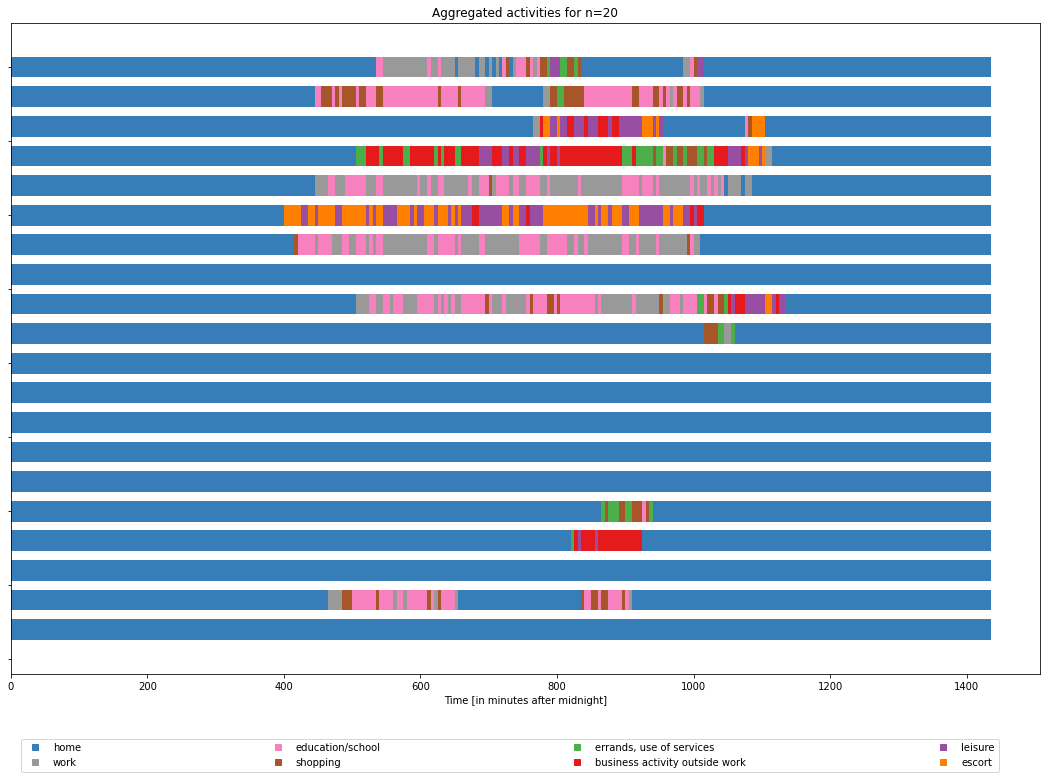

In [0]:
plt.rcParams["figure.figsize"] = [15, 10]
fig, chart_ax = plt.subplots()
plt.rcdefaults()


# In this case we expect only 1 item in the entries list.
y_pos = np.arange(20)

width = 0.7
# Set the 'empty' bar .. this is here to coerce Matplotlib
# to keep the size of the bar smaller on our actual data.
# Otherwise the bar will use all available space.
chart_ax.barh(y_pos, 0, 1.0, align='center', color='white', ecolor='black', label=None)


# Add in the segments of data.

yy = np.arange(20)

time_vec = np.arange(0,1440,5)

for ydx in range(len(yy)): 
    left_pos = 0
    time_del = 0
    for idx in range(288):
        
        segpurpose = pred[idx+(ydx)*288]
        segpurpose = segpurpose.astype(int)
        segstop = time_vec[idx] - time_del
        time_del = time_vec[idx]
        segcol = label_colors[segpurpose]
        chart_ax.barh(y_pos[ydx], [segstop], width, align='center', color=segcol, label=segpurpose , left=left_pos,linewidth=0.5)
        left_pos += segstop
# When daily activities are over one is supposed to be home
    

#chart_ax.set_yticks([1])
chart_ax.invert_yaxis()
chart_ax.set_xlabel('Time [in minutes after midnight]')
chart_ax.set_title('Aggregated activities for n=20')
plt.tight_layout()

patches = [ plt.plot([], marker="s", ls="", color=label_colors[i], 
            label="{:s}".format(purpose_labels[i]) )[0]  for i in range(len(purpose_labels)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.01, -0.15, 0.95, 0.2), loc=4, ncol=4,mode="expand", borderaxespad=0.0 )
chart_ax.set_yticklabels([])
plt.show()






In [0]:
pred1 = []
purpose_binary_fin = []
for i in range(10000):
  G(torch.randn(1, Z_dim))
  S=G(torch.randn(1, Z_dim)).detach()
  S = S*8
  S = S.round()
  S = S.int()
  #print(S)
  pred1 = np.append(pred,S)
  S = S.numpy()
  purpose_binary = [0]*2304
  for n in range(288):
    for m in range(8):
      if S[0][n] == m:
          purpose_binary[m+8*n] = 1          
  purpose_binary_fin.append(purpose_binary)
#print(pred)
np.shape(pred1)

(6048,)

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=1)
kmeans.fit(purpose_binary_fin)
kmeans_labels = kmeans.labels_
kmeans_centers = kmeans.cluster_centers_

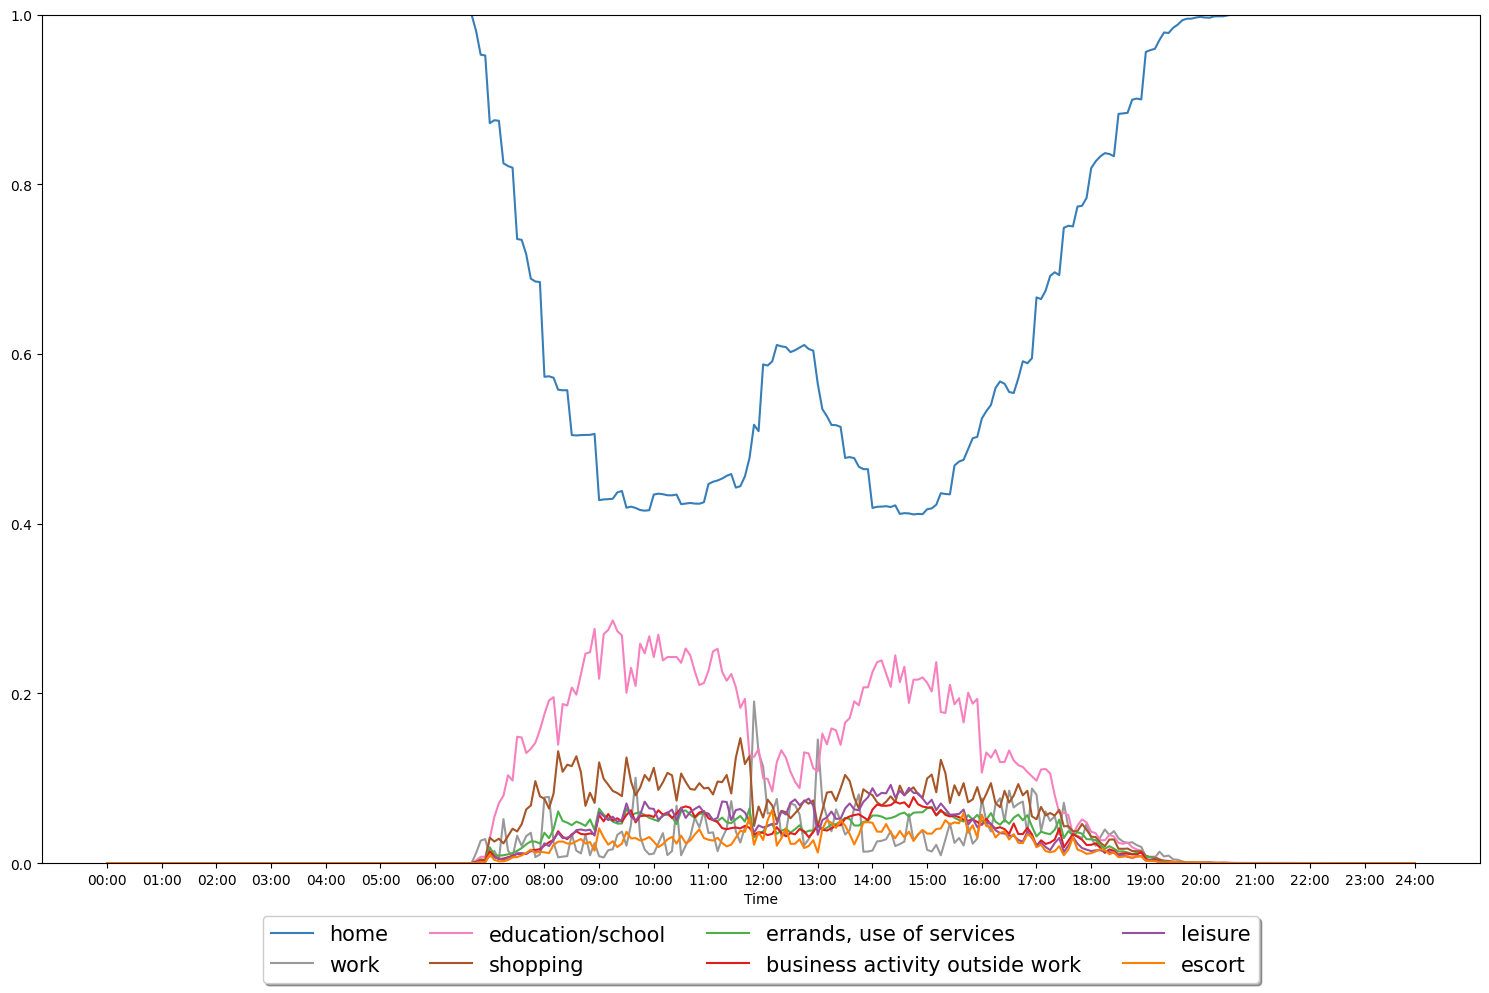

In [0]:
import pandas as pd
plt.rcParams["figure.figsize"] = [15, 10]

for i in range(8):
    ax=pd.DataFrame(kmeans_centers.reshape(1,288,8)[0,:,:])[i].plot(ylim=(0,1),label=i,color=label_colors[i])
#print(kmeans_centers)
patches = [ plt.plot([], color=label_colors[i],label="{:s}".format(purpose_labels[i]) )[0]  for i in range(len(purpose_labels)) ]
ax.legend(handles=patches,loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=4,prop={'size': 15})
kmeans_c0_act1=pd.DataFrame(kmeans_centers.reshape(1,288,8)[0,:,:])[1]
labels = ['00:00','01:00','02:00','03:00','04:00','05:00','06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00','24:00'];
plt.xticks([0,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180,192,204,216,228,240,252,264,276,287], labels);
plt.xlabel('Time')
#plt.title('Cluster 0')
plt.tight_layout()